In [1]:
import shapefile
import glob
import rasterio.mask
import rasterio.warp
import shapely.geometry
import pandas
import numpy as np
import seaborn as sns

In [2]:
from enum import Enum

class ShapeClass(Enum):
    CACAO = 1
    COFFEE = 2
    COMPLEX_OIL = 3
    NATIVEVEGE = 4
    OIL_PALM = 5
    RUBBER = 6
    UNKNOWN = 7
    SEASONAL = 8
    URBAN = 9
    WATER = 10
    OTHER_TREE = 11
    OTHER_NO_TREE = 12
    NATIVE_NO_TREE = 13
    WATER_OTHER = 14
    PEPPER = 15
    CASSAVA = 16
    TEA = 17
    RICE = 18
    BANANA_JUNG = 19
    BABY_PALM = 20
    CUT_OFF_REGROW = 21
    NATURAL_WETLAND = 22
    INTERCROP = 23
    DECIDUOUS_FOREST = 24
    STICK_PEPPER = 25
    FLOODED_PLANTATION = 26
    PINE_TREES = 27
    COCONUT = 28
    BAMBOO = 29
    SAVANA = 30
    MANGO = 31
    OTHER_FRUIT_TREE_CROP = 32
    WATER_MINE = 33

In [3]:
def polygon_nb_px_around_coordinates(coordinate, n, dataset):
    lat = coordinate[0]
    lon = coordinate[1]

    row, col = dataset.index(lat, lon)

    min_coord = rasterio.transform.xy(dataset.transform, row - n, col - n, offset='ul')
    max_coord = rasterio.transform.xy(dataset.transform, row + n, col + n, offset='lr')

    return shapely.geometry.box(min_coord[0], min_coord[1], max_coord[0], max_coord[1])

In [4]:
# Open shapefiles
shapefile_root_path = "labels/"
shapefiles_paths = glob.glob(shapefile_root_path + "**/*.shp")

In [5]:
# Create a dictionary which will contain all
# points classified in the opened shapefiles
# with their coordinates lat-lon
classes_points_coordinates = {}

# Initialize the dictionary
for i in range(1, 34):
    classes_points_coordinates[i] = []

# Add each points coordinate
# in its corresponding class
for path in shapefiles_paths:
    sf = shapefile.Reader(path)

    for shape_record in sf.shapeRecords():
        if shape_record.record.Class <= 33:
            current_list = classes_points_coordinates.get(shape_record.record.Class)
            current_list.append(shape_record.shape.points[0])
            classes_points_coordinates[shape_record.record.Class] = current_list

In [6]:
def write_raster_to_disk(raster, metadata, transform, crs, filename):
    metadata.update({
        "driver": "GTiff",
        "height": raster.shape[1],
        "width": raster.shape[2],
        "transform": transform,
        "crs": crs
    })

    # Write merged raster to disk
    with rasterio.open('./tiles/' + filename, "w", **metadata) as dest:
        dest.write(raster)

In [7]:
def raster_n_px_around_tagged_point(coordinates, nb_pixel_around, initial_raster):
    polygon = polygon_nb_px_around_coordinates(coordinates, nb_pixel_around, initial_raster)
    return rasterio.mask.mask(initial_raster, shapes=[polygon], crop=True)

In [8]:
NB_PIXEL_AROUND_POINT = 4

In [9]:
def tagged_points_bands_values(point_class, initial_raster):
    values = []

    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)

        values.append([
            np.mean(out_img[0]),
            np.mean(out_img[1]),
            np.mean(out_img[2]),
            np.mean(out_img[3]),
            np.mean(out_img[4]),
            np.mean(out_img[5]),
            np.mean(out_img[6]),
            np.mean(out_img[7]),
            np.mean(out_img[9]),
        ])

    return np.array(values)

In [10]:
def write_raster_around_tagged_points(point_class, initial_raster):
    i = 0
    for coordinates in classes_points_coordinates[point_class]:
        out_img, out_transform = raster_n_px_around_tagged_point(coordinates, NB_PIXEL_AROUND_POINT, initial_raster)
        
        write_raster_to_disk(
            out_img,
            initial_raster.meta.copy(),
            out_transform,
            initial_raster.crs.to_proj4(),
            filename = str(ShapeClass(point_class).name) + '_' + str(i) + '.tif'
        )
        
        i += 1

#  Coffee comparison to other entities

In [11]:
def coffee_comparison_to_other_entities(raster_path):
    # Open raster
    initial_raster = rasterio.open(raster_path) 
    
    # Get values for each label we are interested in
    coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, initial_raster)
    pepper_values = tagged_points_bands_values(ShapeClass.PEPPER.value, initial_raster)
    tea_values = tagged_points_bands_values(ShapeClass.TEA.value, initial_raster)
    urban_values = tagged_points_bands_values(ShapeClass.URBAN.value, initial_raster)
    water_values = tagged_points_bands_values(ShapeClass.WATER.value, initial_raster)
    
    # Create dataframes from those values
    columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic', 'tirs 1']
    coffee_df = pandas.DataFrame(coffee_values, columns=columns).assign(label="Coffee")
    pepper_df = pandas.DataFrame(pepper_values, columns=columns).assign(label="Pepper")
    tea_df = pandas.DataFrame(tea_values, columns=columns).assign(label="Tea")
    urban_df = pandas.DataFrame(urban_values, columns=columns).assign(label="Urban")
    water_df = pandas.DataFrame(water_values, columns=columns).assign(label="Water")

    # Concatenate all those dataframe into one
    concat_df = pandas.concat([coffee_df, pepper_df, tea_df, urban_df, water_df])

    # Draw boxplot
    df = pandas.melt(concat_df, id_vars=['label'], var_name=['Bands'])
    boxplot = sns.boxplot(x="Bands", y="value", hue="label", data=df, palette="Set3")
    boxplot.set_ylim([0, 4800]) 

    # Draw Scatter plot
    sns.relplot(x="red", y="nir", hue="label", data=concat_df, palette="Set3");

In [12]:
# Set seaborn figures sizes
sns.set(rc={'figure.figsize':(15,12)})

## Monsoon

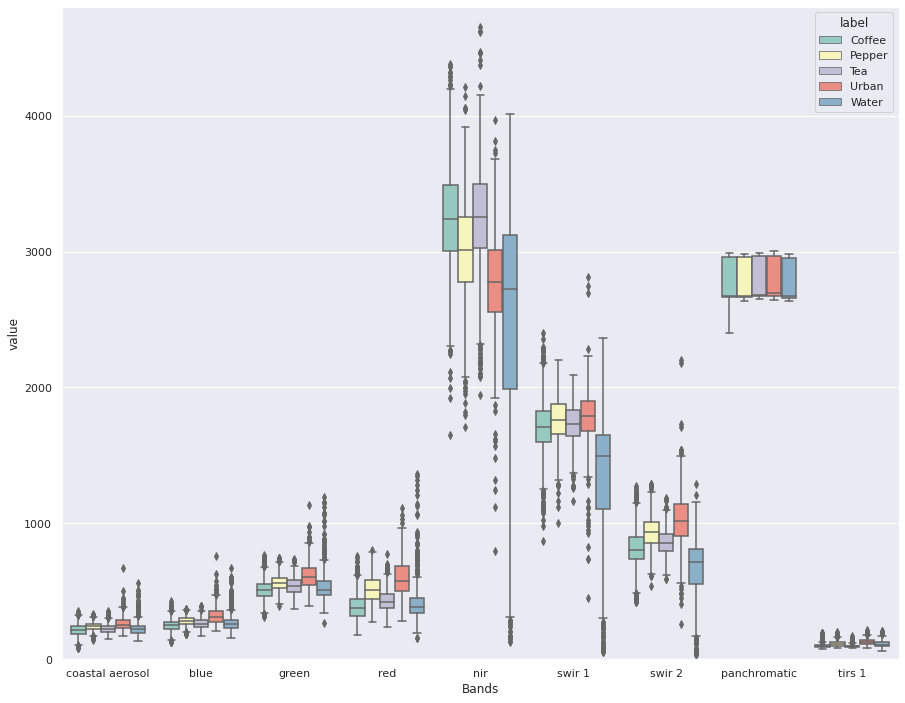

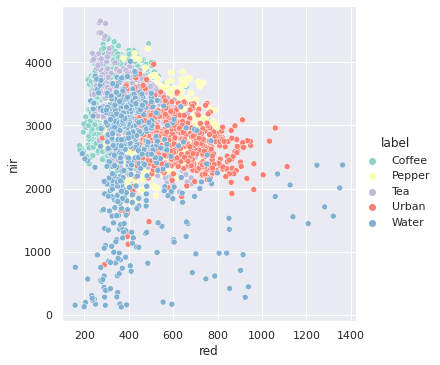

In [13]:
coffee_comparison_to_other_entities('./Vietnam_2014-2016_monsoon_june_november/merged.tif')

## Summer

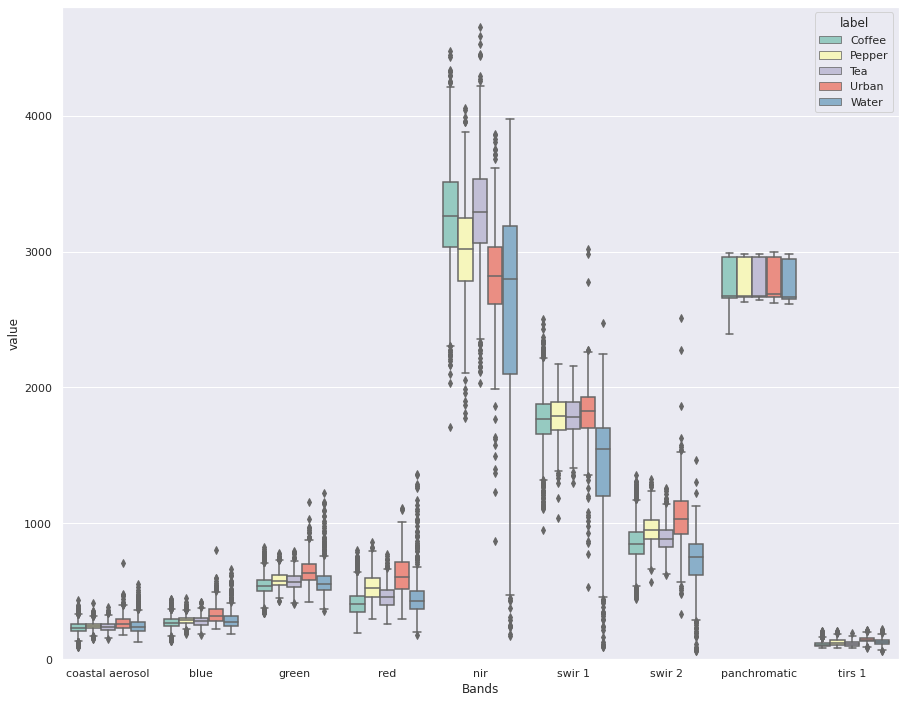

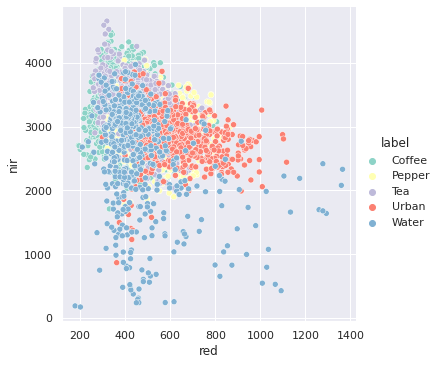

In [14]:
coffee_comparison_to_other_entities('./Vietnam_2014-2016_summer_may_october/merged.tif')

## Winter

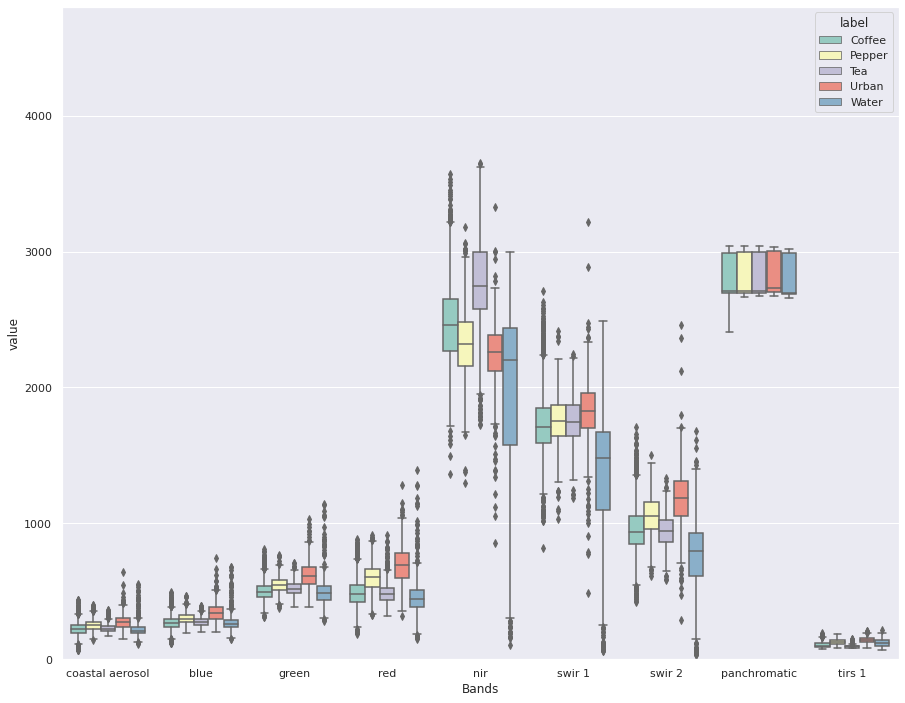

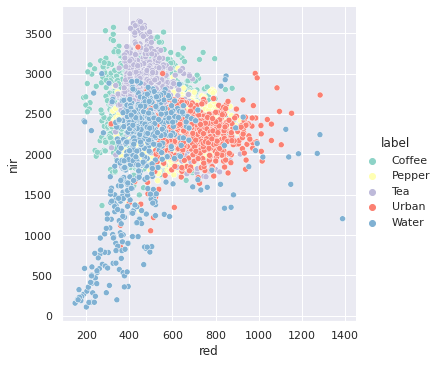

In [15]:
coffee_comparison_to_other_entities('./Vietnam_2014-2016_winter_november_april/merged.tif')

# Coffee comparison by season

Si l'on compare le café entre la période d'hiver au Vietnam (novembre à avril) et la période d'été (mai à octobre), on peut remarquer certaines différences intéressantes.

- La variablité de toutes les bandes est moins grande en été qu'en hiver.
- La valeur de la bande infrarouge (nir) augmente fortement en été passant d'une médiane de 2351 à une médiane de 2799  

In [16]:
winter_raster_path = './Vietnam_2014-2016_winter_november_april/merged.tif'
winter_initial_raster = rasterio.open(winter_raster_path) # Open raster
winter_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, winter_initial_raster)

summer_raster_path = './Vietnam_2014-2016_summer_may_october/merged.tif'
summer_initial_raster = rasterio.open(summer_raster_path) # Open raster
summer_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, summer_initial_raster)

monsoon_raster_path = './Vietnam_2014-2016_monsoon_june_november/merged.tif'
monsoon_initial_raster = rasterio.open(monsoon_raster_path) # Open raster
monsoon_coffee_values = tagged_points_bands_values(ShapeClass.COFFEE.value, monsoon_initial_raster)

Winter:
        coastal aerosol         blue        green          red          nir  \
count      4109.000000  4109.000000  4109.000000  4109.000000  4109.000000   
mean        225.331901   272.472294   501.766884   489.636689  2467.888274   
std          44.412898    47.188685    66.179310   101.602220   288.690739   
min          66.422222   117.883333   310.272222   187.222222  1365.566667   
25%         195.858025   240.272222   456.066667   418.400000  2269.765432   
50%         219.866667   267.505556   493.877778   477.327160  2459.405556   
75%         251.500000   299.488889   539.820988   547.266667  2649.350000   
max         439.038889   497.018519   812.345679   881.567901  3574.253086   

            swir 1       swir 2  panchromatic       tirs 1  
count  4109.000000  4109.000000   4109.000000  4109.000000  
mean   1735.333773   957.370980   2828.296068   105.531177  
std     219.447980   161.895015    150.339264    21.768916  
min     818.300000   423.544444   2411.97500

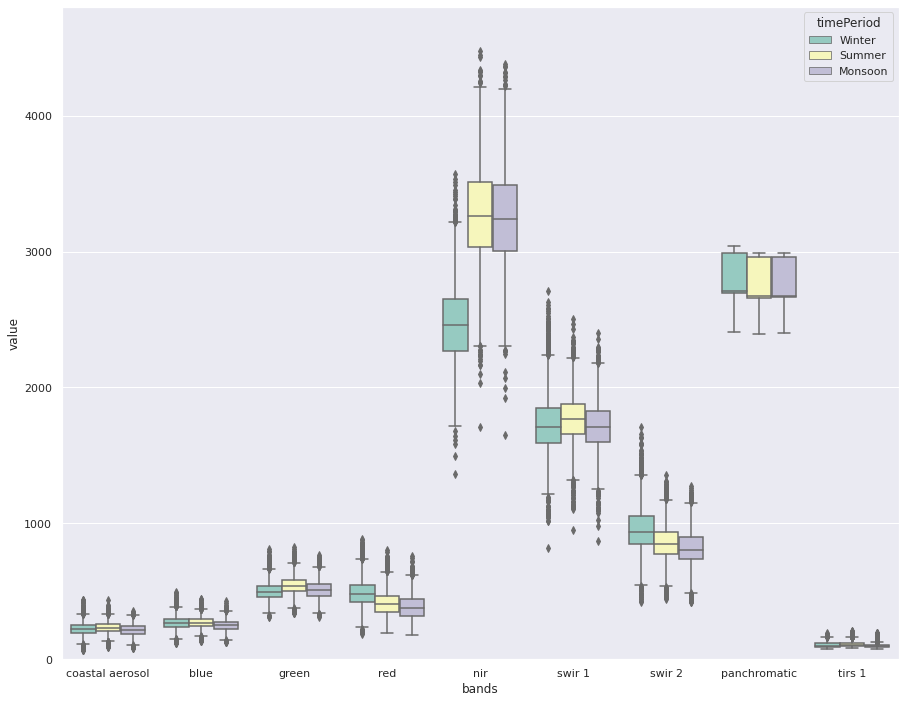

In [17]:
columns = ['coastal aerosol', 'blue', 'green', 'red', 'nir', 'swir 1', 'swir 2', 'panchromatic', 'tirs 1']

# Create a dataframe containing the data of each bands
winter_coffee_df = pandas.DataFrame(winter_coffee_values, columns=columns).assign(timePeriod='Winter')
summer_coffee_df = pandas.DataFrame(summer_coffee_values, columns=columns).assign(timePeriod='Summer')
monsoon_coffee_df = pandas.DataFrame(monsoon_coffee_values, columns=columns).assign(timePeriod='Monsoon')

concat_df = pandas.concat([winter_coffee_df, summer_coffee_df, monsoon_coffee_df])
df = pandas.melt(concat_df, id_vars=['timePeriod'], var_name=['bands'])
boxplot = sns.boxplot(x="bands", y="value", hue="timePeriod", data=df, palette="Set3")
boxplot.set_ylim([0, 4800])

print("Winter:\n", winter_coffee_df.describe(), "\n")
print("Summer:\n", summer_coffee_df.describe(), "\n")
print("Monsoon:\n", monsoon_coffee_df.describe(), "\n")